In [1]:
import tensorflow as tf
from utility.initialize_tf import ReturnBestEarlyStopping
from utility.data_loading import *
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from utility.display_prediction_results import *
from utility.data_preprocessing import *
from utility.results_helper import *
import custom_models.esnet as esnet

2.5.0
2.5.0


In [2]:
mesh = 100
input_shape = (mesh, mesh, 1)

# model_save_path = f'saved_models\\result_models\\final\\esnet\\sim_with_gaussian_noise'
# transfer_model_save_path = f'saved_models\\result_models\\final\\esnet\\transferred_from_sim_with_gaussian_noise'
model_save_path = f'saved_models\\result_models\\final\\esnet\\sim'#_with_moffat_noise_enhanced_noise'
transfer_model_save_path = f'saved_models\\result_models\\final\\esnet\\transferred'#_from_sim_with_moffat_noise_enhanced_noise'
tuned_model_save_path = f'saved_models\\result_models\\final\\esnet\\tuned'#_from_sim_with_moffat_noise_enhanced_noise'

training_data_name = "fd=0.3-0.7_hdf5"
#training_data_name = "fd=0.3-0.9_orig_200_hdf5"
testing_data = "califa_s_1.0"
#testing_data = "califa_s_1.0_mesh_200"
training_validation_split = 0.7
transfer_validation_split = 0.5

In [3]:
x_dataset, y_dataset, train_metadata = load_hdf5_data(name=training_data_name, count=None)

x_cal, y_cal, cal_metadata = load_hdf5_data(name=testing_data)
x_cal = np.expand_dims(x_cal, axis=3)
y_cal = np.expand_dims(y_cal, axis=1)


E:\Anaconda3\envs\esnet-gpu\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


(54000, 100, 100)
(79, 100, 100)


In [4]:
#add_background_galaxies(x_dataset)

#apply_gaussian_PSF(x_dataset, 0.218598726) # General Gaussian PSF 0.218598726 0.573292215 1.3 20.84 8.85
#add_gaussian_noise(x_dataset, noise_range=[0.04, 0.06])
#add_point_sources(x_dataset)
add_background_galaxies_moffat(x_dataset)

apply_moffat_PSF(x_dataset, 4.148122, 4.765) #4.765 #g 0.65049197562297747917932881055243, #1.642657, # 3.219567, 3.0 # 2.90387, 2.5 # 4.148122, 4.765
#apply_gaussian_PSF(x_dataset, 0.218598726)

x_dataset = np.expand_dims(x_dataset, axis=3)
#y_dataset = np.expand_dims(y_dataset, axis=1)

x_train, x_val, y_train, y_val = train_test_split(x_dataset, y_dataset, shuffle=True, train_size=training_validation_split, random_state=2021, stratify=y_dataset)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, shuffle=True, train_size=2/3, random_state=2021, stratify=y_val)

train_datagen = create_datagen(x_train)
val_datagen = create_datagen(x_val)
print(y_val.shape)
sss = StratifiedShuffleSplit(n_splits=3, test_size=transfer_validation_split, random_state=2021)


(10800,)


(37800, 100, 100, 1)
(79, 100, 100, 1)


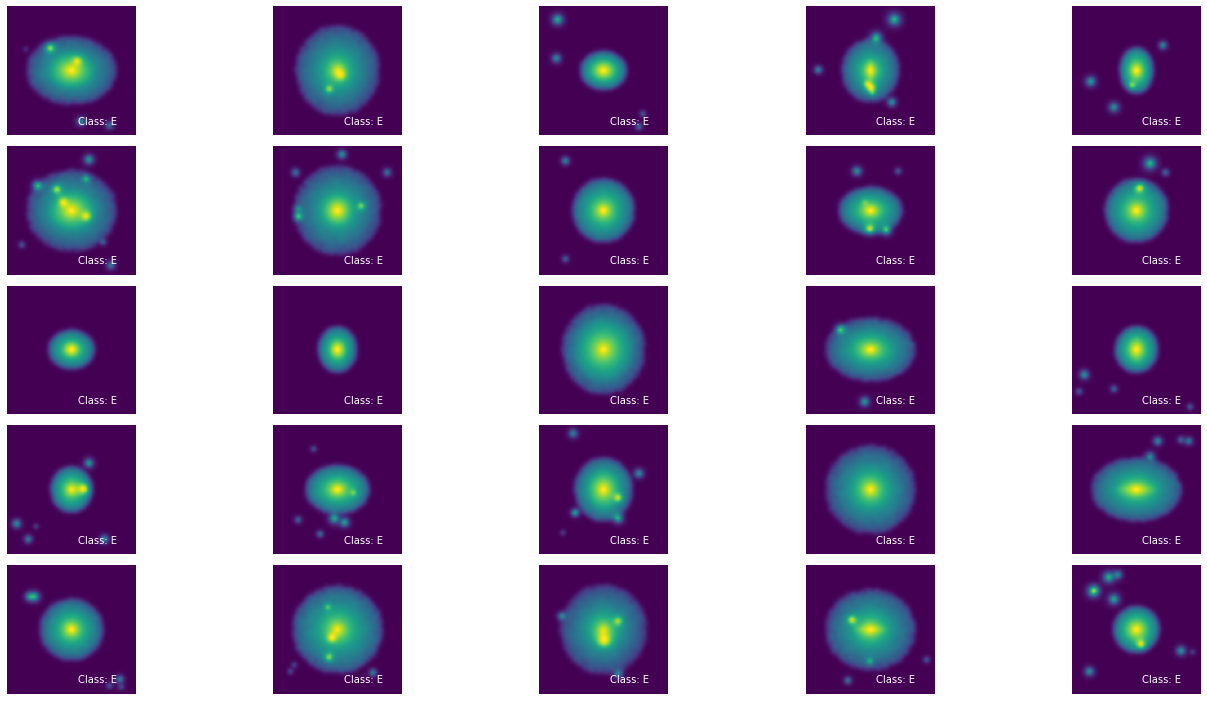

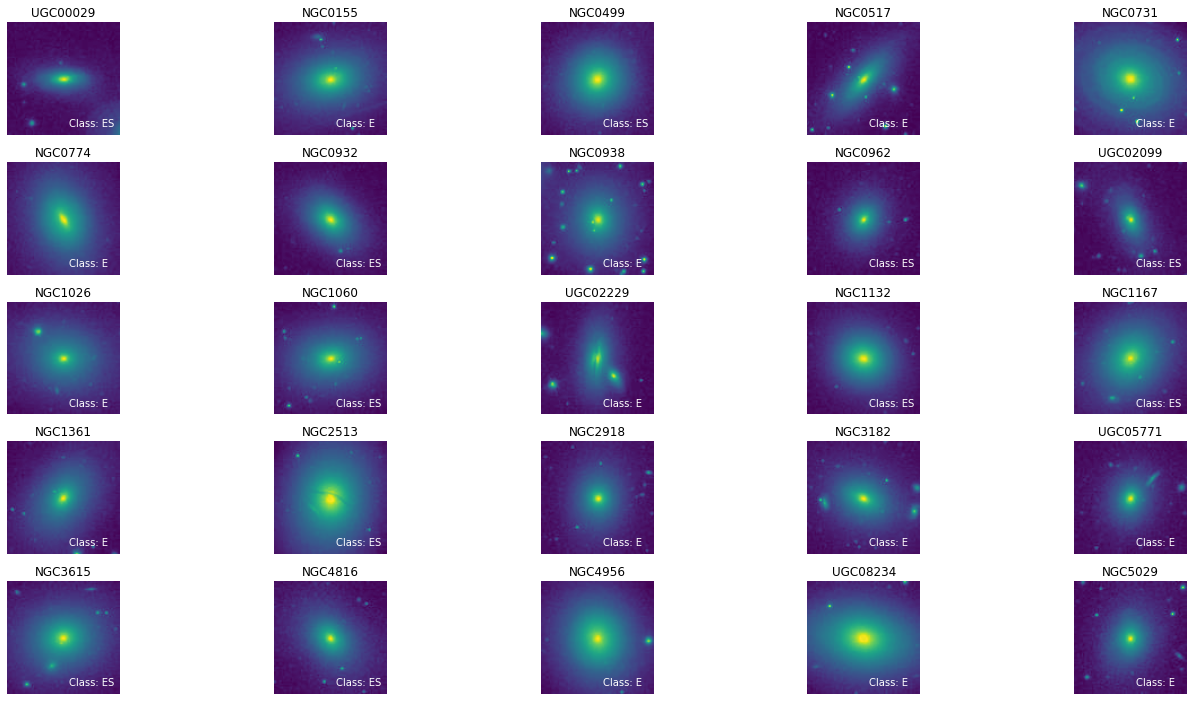

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20, 10]
mpl.rcParams['figure.dpi'] = 72
plot_dataset(x_train, train_metadata)
plot_dataset(x_cal, cal_metadata)
print(x_train.shape)
print(x_cal.shape)

In [6]:
import importlib
importlib.reload(esnet)

esnet.build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 47, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 16)        64        
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0

In [7]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1)

In [8]:
early_stopping_callback = ReturnBestEarlyStopping(monitor='val_binary_accuracy', patience=50, restore_best_weights=True, verbose=1)
learning_rate_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint("./esnet/esnet_model_at_{epoch:02d}.hdf5", monitor='loss', verbose=1,
    save_best_only=False, mode='auto', save_freq='epoch')

train_datagen = create_datagen(x_train)

model, train_history = esnet.train_model(x_train, y_train, x_cal, y_cal, datagen = train_datagen, lr=0.001, epochs=200, batch_size=128, callbacks = [early_stopping_callback, model_checkpoint_callback],
                                         metrics=['AUC', 'accuracy', 'binary_accuracy'])
model.save(model_save_path, save_traces=True, include_optimizer=True)

Epoch 1/200
296/296 [==============================] - 72s 114ms/step - loss: 3.3319 - binary_crossentropy: 0.7832 - auc: 0.5310 - accuracy: 0.5228 - binary_accuracy: 0.5228 - val_loss: 1.4356 - val_binary_crossentropy: 0.6931 - val_auc: 0.5300 - val_accuracy: 0.4810 - val_binary_accuracy: 0.4810

Epoch 00001: saving model to ./esnet\esnet_model_at_01.hdf5
Epoch 2/200
296/296 [==============================] - 35s 117ms/step - loss: 1.3910 - binary_crossentropy: 0.7113 - auc: 0.5343 - accuracy: 0.5246 - binary_accuracy: 0.5246 - val_loss: 1.2216 - val_binary_crossentropy: 0.6699 - val_auc: 0.6508 - val_accuracy: 0.5823 - val_binary_accuracy: 0.5823

Epoch 00002: saving model to ./esnet\esnet_model_at_02.hdf5
Epoch 3/200
296/296 [==============================] - 33s 111ms/step - loss: 1.1602 - binary_crossentropy: 0.6976 - auc: 0.5241 - accuracy: 0.5164 - binary_accuracy: 0.5164 - val_loss: 1.2335 - val_binary_crossentropy: 0.7330 - val_auc: 0.3740 - val_accuracy: 0.4177 - val_binary_a

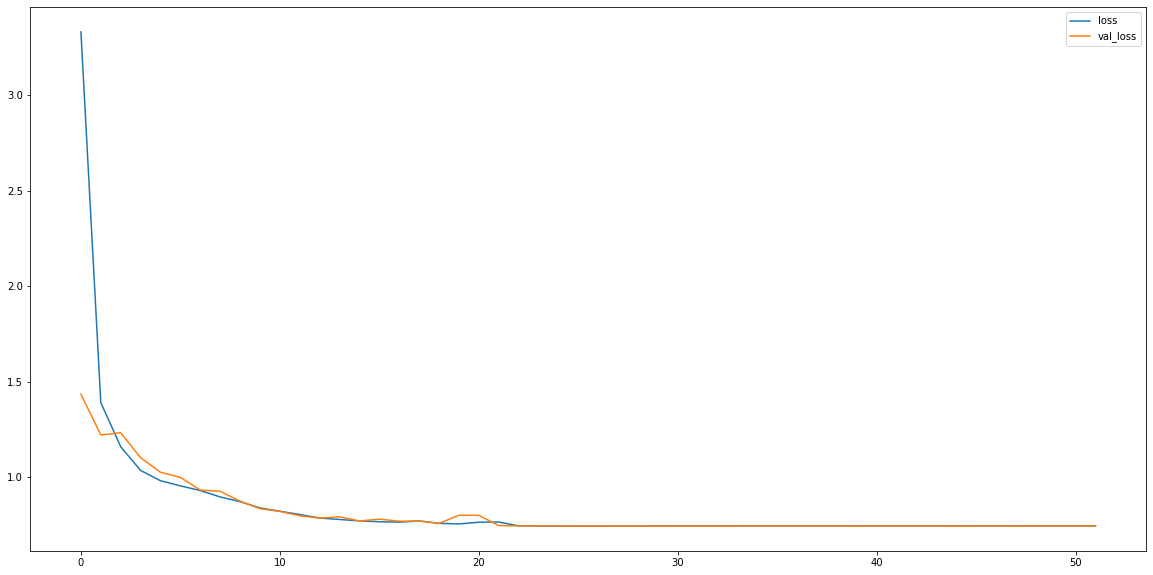

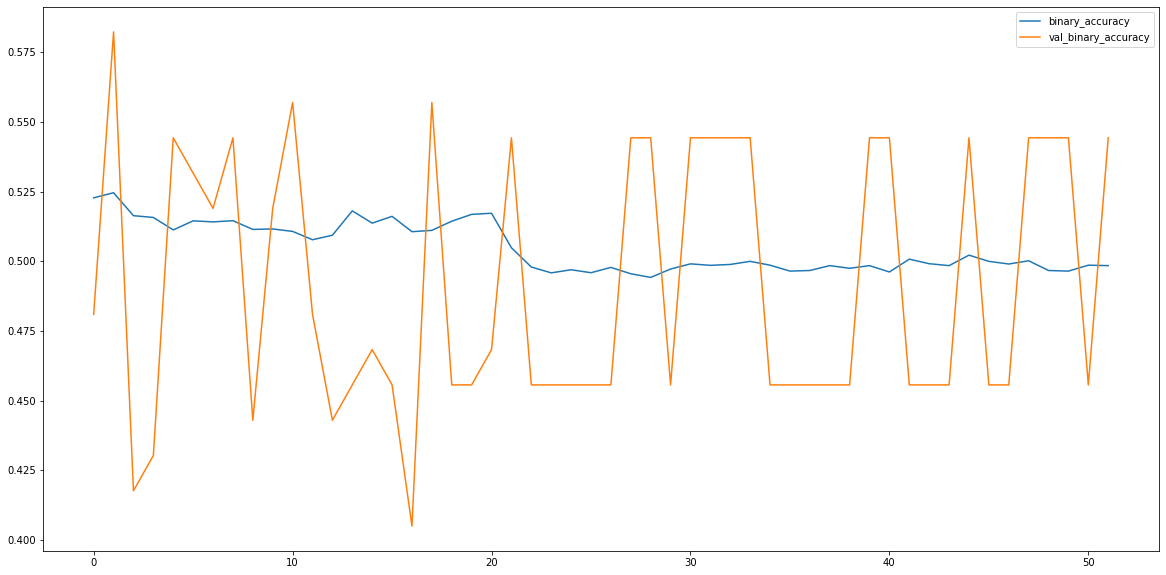

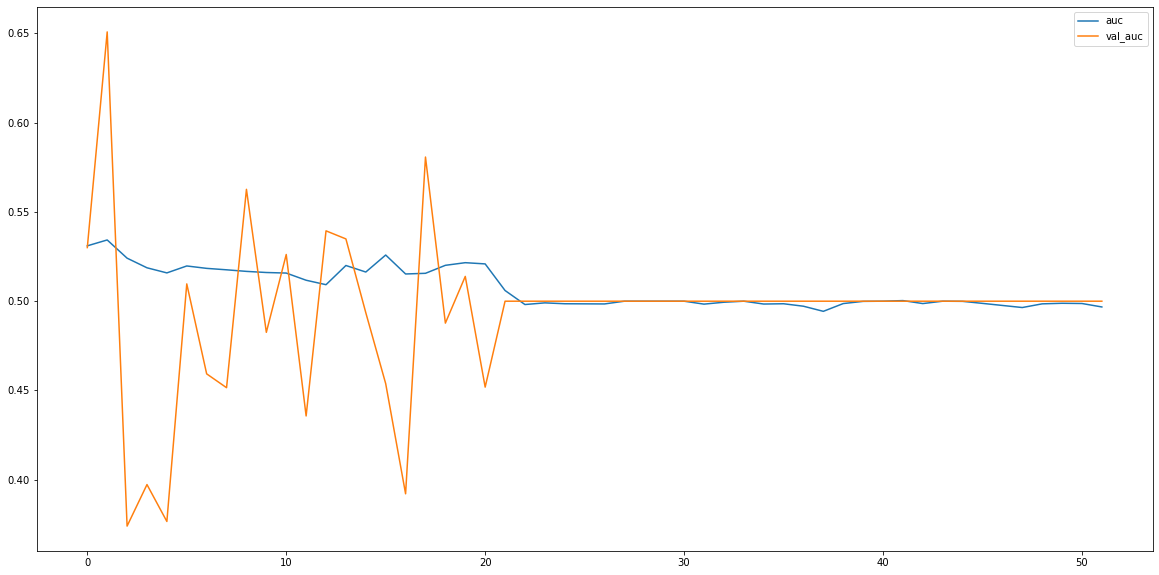

In [9]:
plot_learning_curves(train_history, metrics = ['loss', 'sparse_categorical_accuracy', 'binary_accuracy', 'auc'])

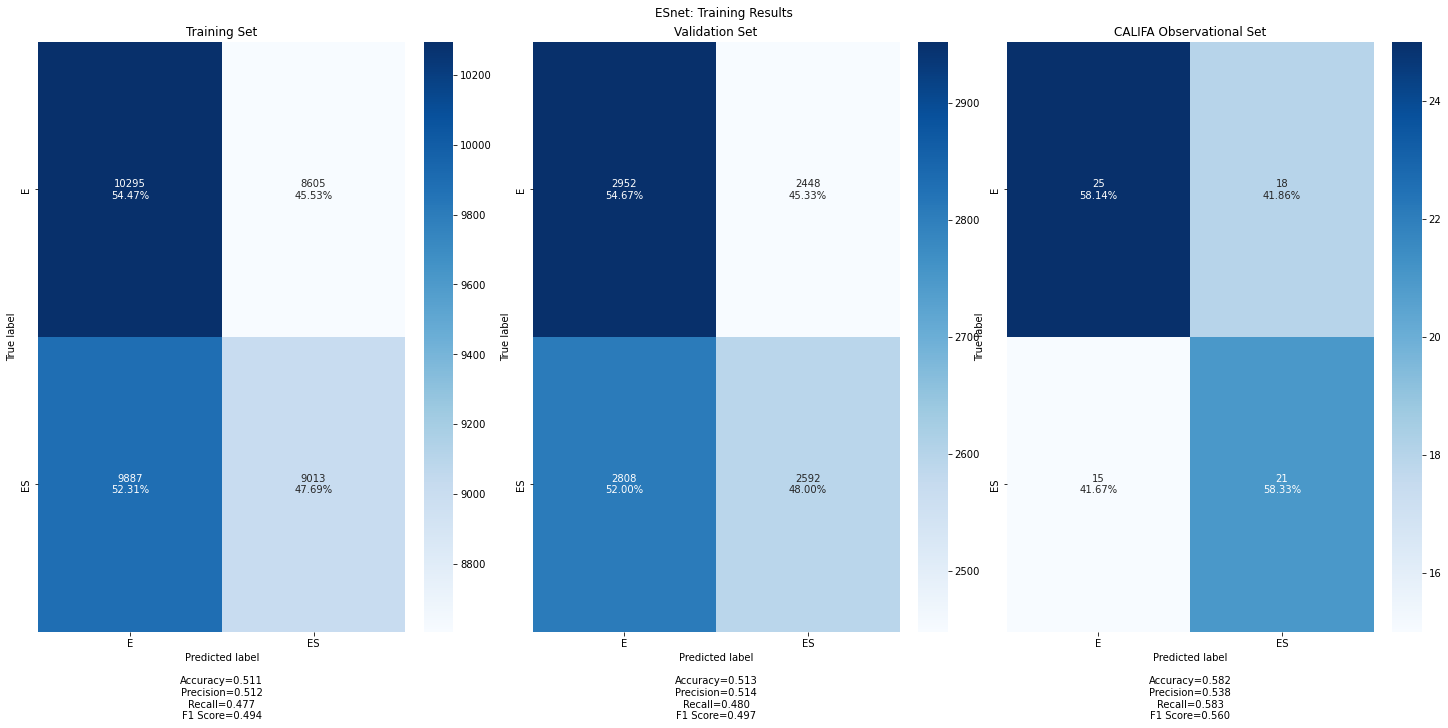

In [10]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20, 10]
mpl.rcParams['figure.dpi'] = 72
#model = tf.keras.models.load_model(".\\saved_models\\result_models\\final\\esnet\\sim_with_moffat_noise")

plot_results([get_results(model, x_train, y_train), get_results(model, x_val, y_val), get_results(model, x_cal, y_cal)], average = False,
    title="ESnet: Training Results",
    subplot_titles=["Training Set", "Validation Set", "CALIFA Observational Set"])


Epoch 1/5000
1/1 [==============================] - 2s 2s/step - loss: 8.0804 - binary_crossentropy: 0.8461 - binary_accuracy: 0.4359 - auc: 0.5304 - val_loss: 8.0996 - val_binary_crossentropy: 0.8419 - val_binary_accuracy: 0.3750 - val_auc: 0.3573
Epoch 2/5000
1/1 [==============================] - 0s 98ms/step - loss: 8.2482 - binary_crossentropy: 1.0227 - binary_accuracy: 0.5385 - auc: 0.4934 - val_loss: 8.1205 - val_binary_crossentropy: 0.8703 - val_binary_accuracy: 0.4000 - val_auc: 0.3396
Epoch 3/5000
1/1 [==============================] - 0s 95ms/step - loss: 8.2087 - binary_crossentropy: 0.9888 - binary_accuracy: 0.4872 - auc: 0.4259 - val_loss: 8.1153 - val_binary_crossentropy: 0.8726 - val_binary_accuracy: 0.3500 - val_auc: 0.3561
Epoch 4/5000
1/1 [==============================] - 0s 92ms/step - loss: 8.1158 - binary_crossentropy: 0.9034 - binary_accuracy: 0.4103 - auc: 0.4431 - val_loss: 8.1086 - val_binary_crossentropy: 0.8735 - val_binary_accuracy: 0.3500 - val_auc: 0.375

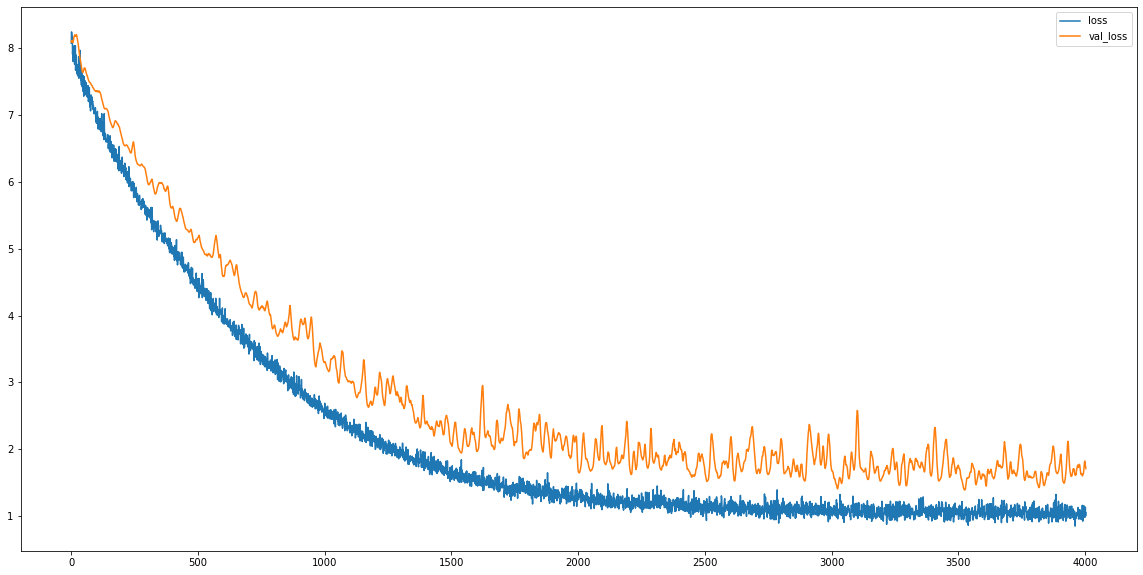

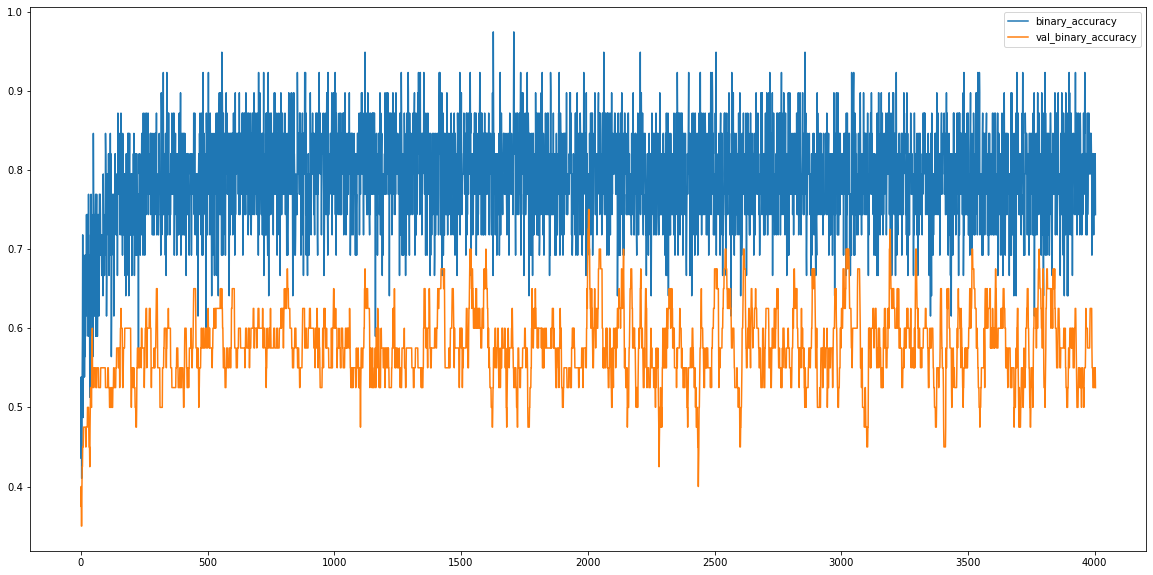

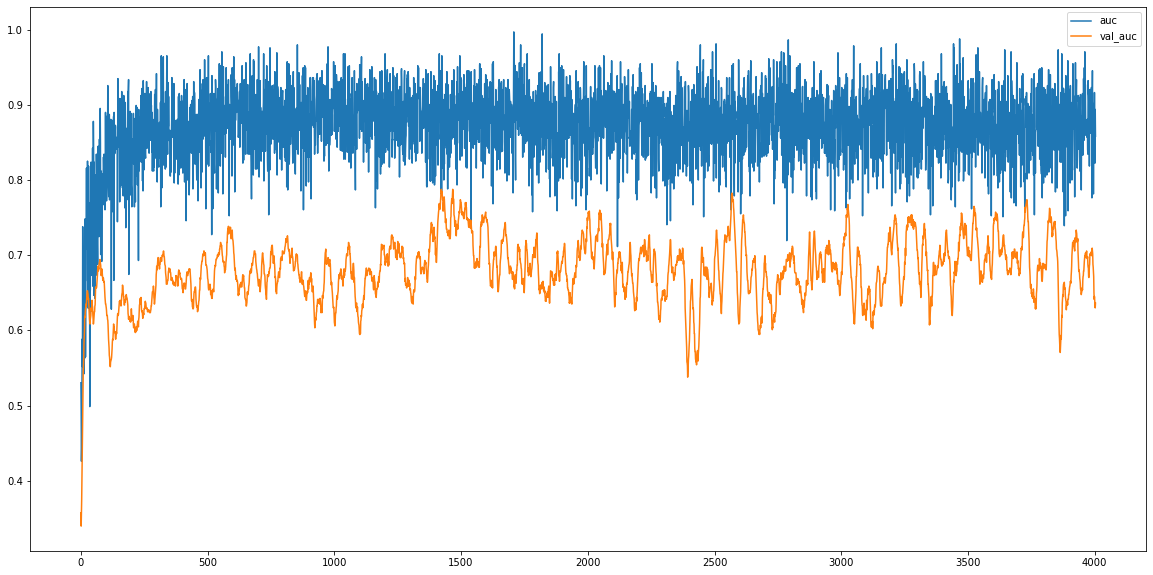

INFO:tensorflow:Assets written to: saved_models\result_models\final\esnet\transferred_skf=0\assets
Epoch 1/5000
1/1 [==============================] - 2s 2s/step - loss: 8.0981 - binary_crossentropy: 0.8620 - binary_accuracy: 0.4872 - auc: 0.4960 - val_loss: 7.9484 - val_binary_crossentropy: 0.6922 - val_binary_accuracy: 0.5500 - val_auc: 0.5758
Epoch 2/5000
1/1 [==============================] - 0s 94ms/step - loss: 8.2667 - binary_crossentropy: 1.0369 - binary_accuracy: 0.4103 - auc: 0.3638 - val_loss: 7.9364 - val_binary_crossentropy: 0.6866 - val_binary_accuracy: 0.5250 - val_auc: 0.5947
Epoch 3/5000
1/1 [==============================] - 0s 93ms/step - loss: 8.0998 - binary_crossentropy: 0.8755 - binary_accuracy: 0.5385 - auc: 0.5357 - val_loss: 7.9397 - val_binary_crossentropy: 0.6965 - val_binary_accuracy: 0.5500 - val_auc: 0.6061
Epoch 4/5000
1/1 [==============================] - 0s 94ms/step - loss: 8.0342 - binary_crossentropy: 0.8176 - binary_accuracy: 0.5897 - auc: 0.6124 

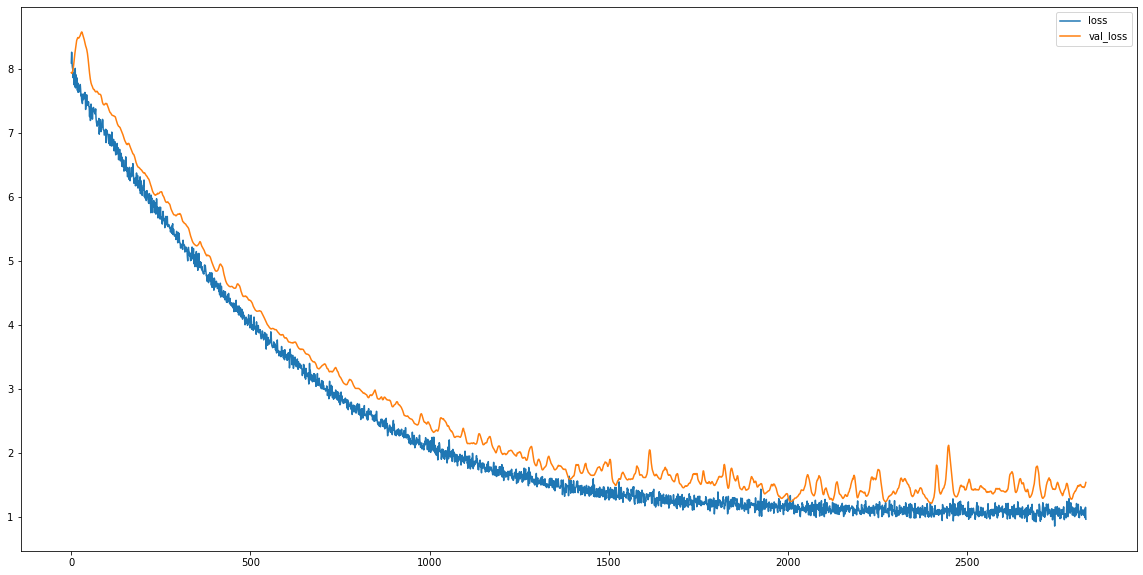

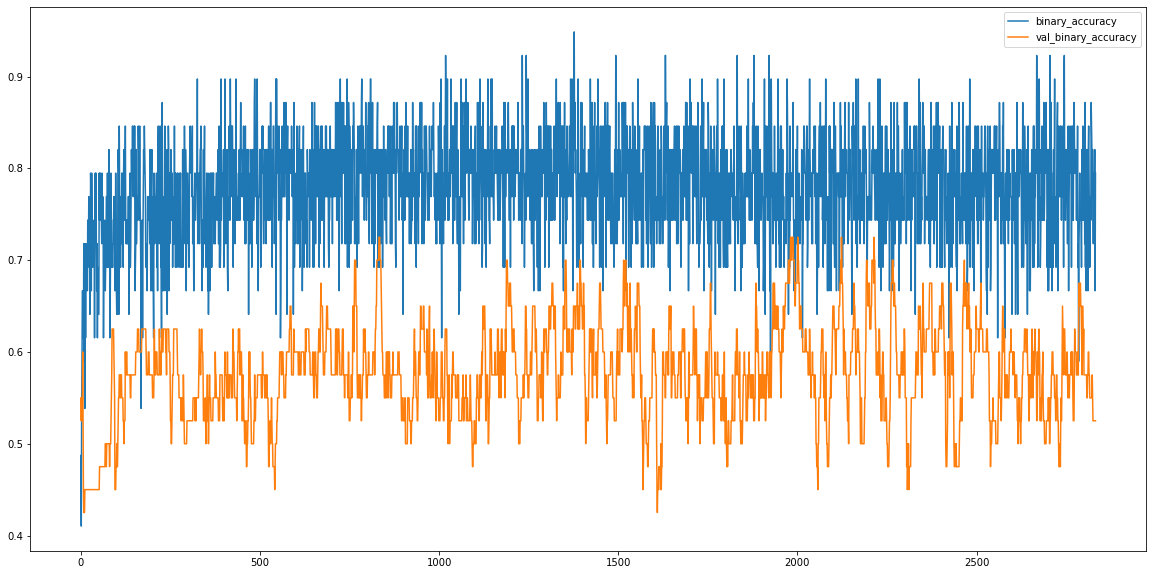

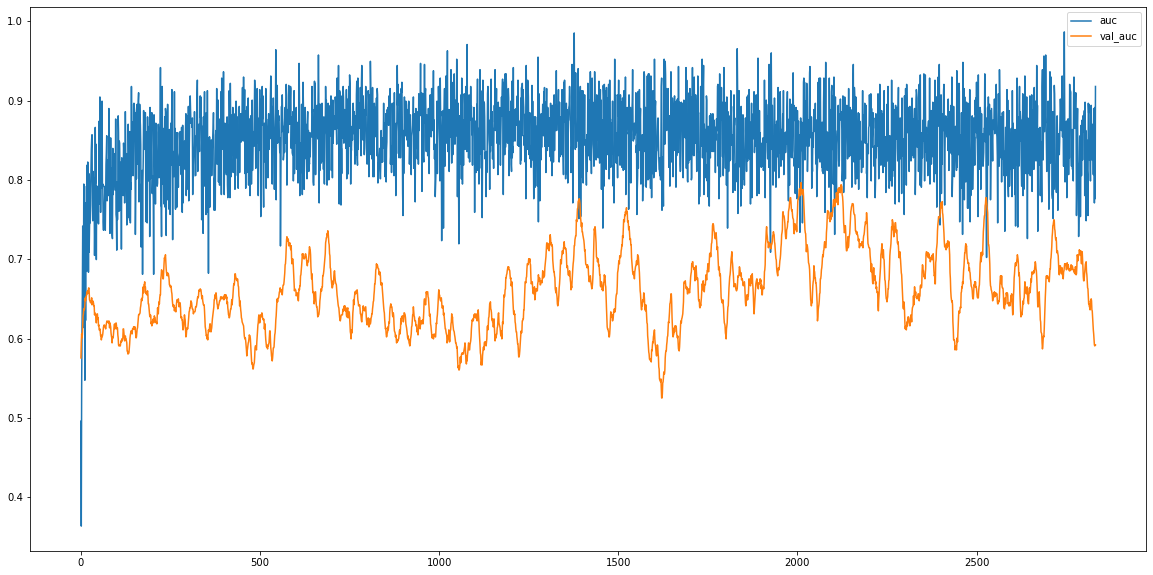

INFO:tensorflow:Assets written to: saved_models\result_models\final\esnet\transferred_skf=1\assets
Epoch 1/5000
1/1 [==============================] - 2s 2s/step - loss: 8.0496 - binary_crossentropy: 0.8145 - binary_accuracy: 0.5128 - auc: 0.5053 - val_loss: 8.0028 - val_binary_crossentropy: 0.7535 - val_binary_accuracy: 0.5750 - val_auc: 0.5505
Epoch 2/5000
1/1 [==============================] - 0s 114ms/step - loss: 8.0515 - binary_crossentropy: 0.8243 - binary_accuracy: 0.5128 - auc: 0.5119 - val_loss: 7.9955 - val_binary_crossentropy: 0.7555 - val_binary_accuracy: 0.6000 - val_auc: 0.6073
Epoch 3/5000
1/1 [==============================] - 0s 120ms/step - loss: 8.1274 - binary_crossentropy: 0.9080 - binary_accuracy: 0.4615 - auc: 0.4484 - val_loss: 7.9810 - val_binary_crossentropy: 0.7504 - val_binary_accuracy: 0.6000 - val_auc: 0.6477
Epoch 4/5000
1/1 [==============================] - 0s 124ms/step - loss: 8.0450 - binary_crossentropy: 0.8384 - binary_accuracy: 0.6154 - auc: 0.60

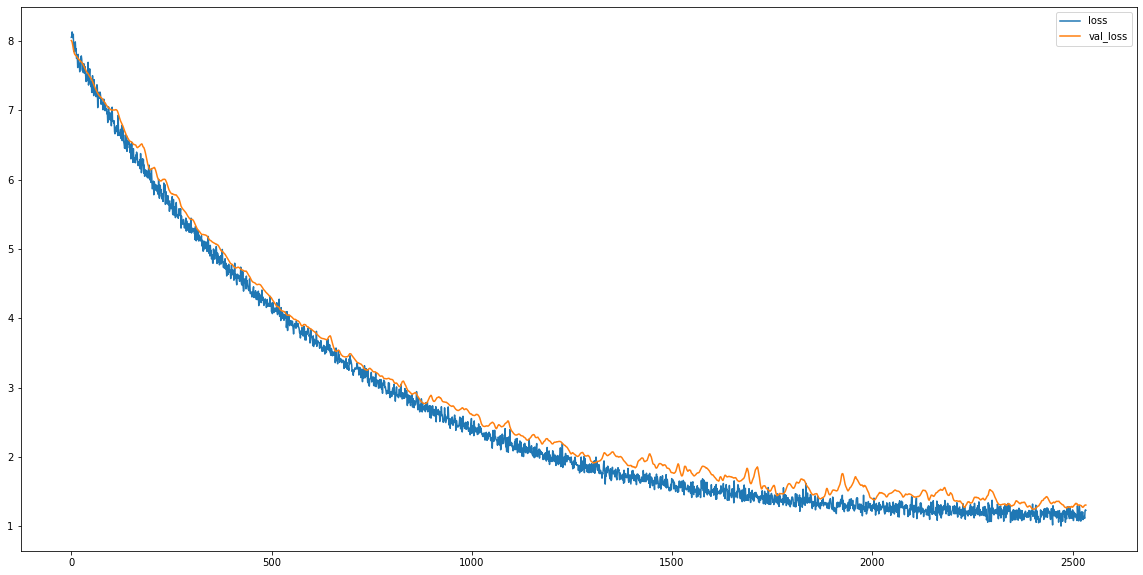

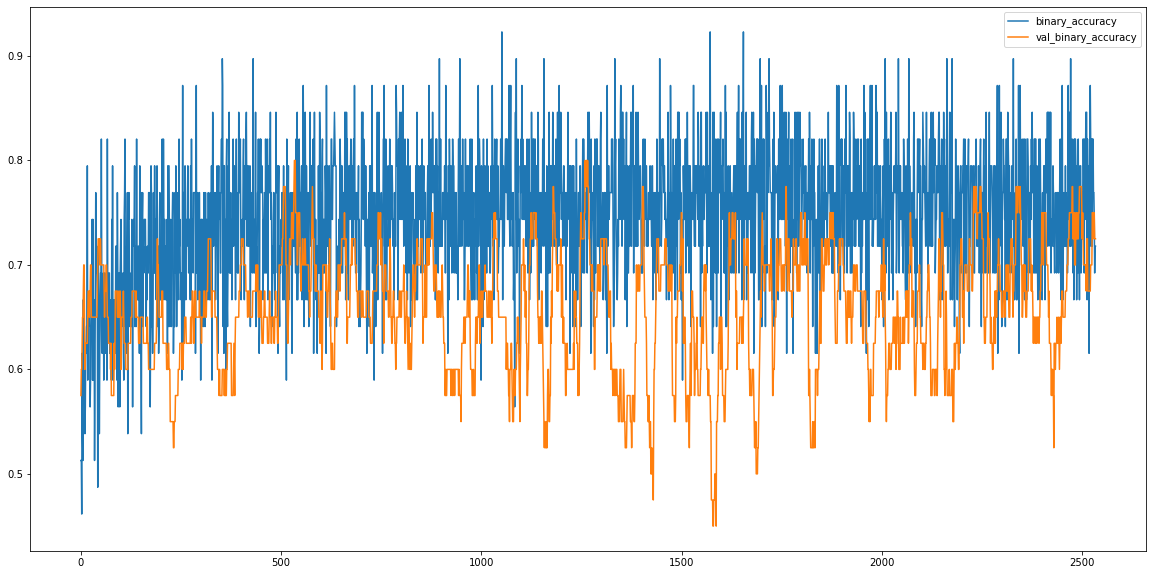

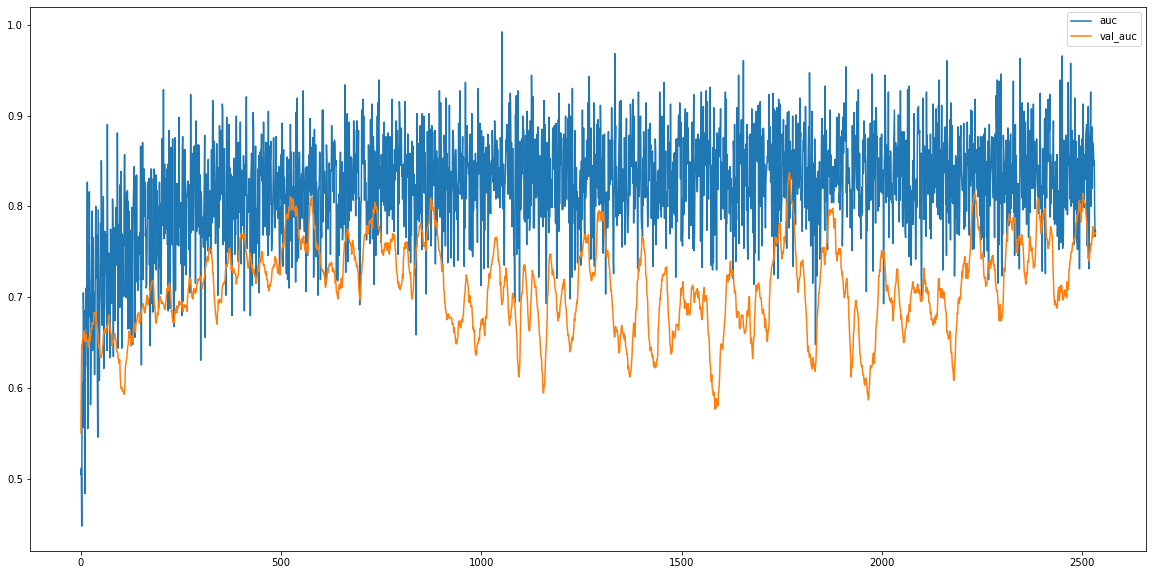

INFO:tensorflow:Assets written to: saved_models\result_models\final\esnet\transferred_skf=2\assets


In [11]:
#model_save_path = f'saved_models\\result_models\\final\\esnet\\sim_with_moffat_noise'
#model = tf.keras.models.load_model(f".\\esnet\\esnet_model_at_24.hdf5")
early_stopping_callback = ReturnBestEarlyStopping(monitor='val_binary_accuracy', patience=2000, restore_best_weights=True, verbose=1)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', patience=3000, cooldown=10)
for i, (train_index, val_index) in enumerate(sss.split(x_cal, y_cal)):
    train_datagen = create_datagen(x_cal[train_index])
    val_datagen = create_datagen(x_cal[val_index])
    transfer_model, transfer_history = esnet.transfer_model(model, x_cal[train_index], y_cal[train_index], x_cal[val_index], y_cal[val_index],
        datagen = train_datagen, callbacks = [early_stopping_callback], metrics=['binary_accuracy', 'AUC'], epochs = 5000, lr = 0.0001)
    plot_learning_curves(transfer_history)
    transfer_model.save(f"{transfer_model_save_path}_skf={i}", overwrite=True)

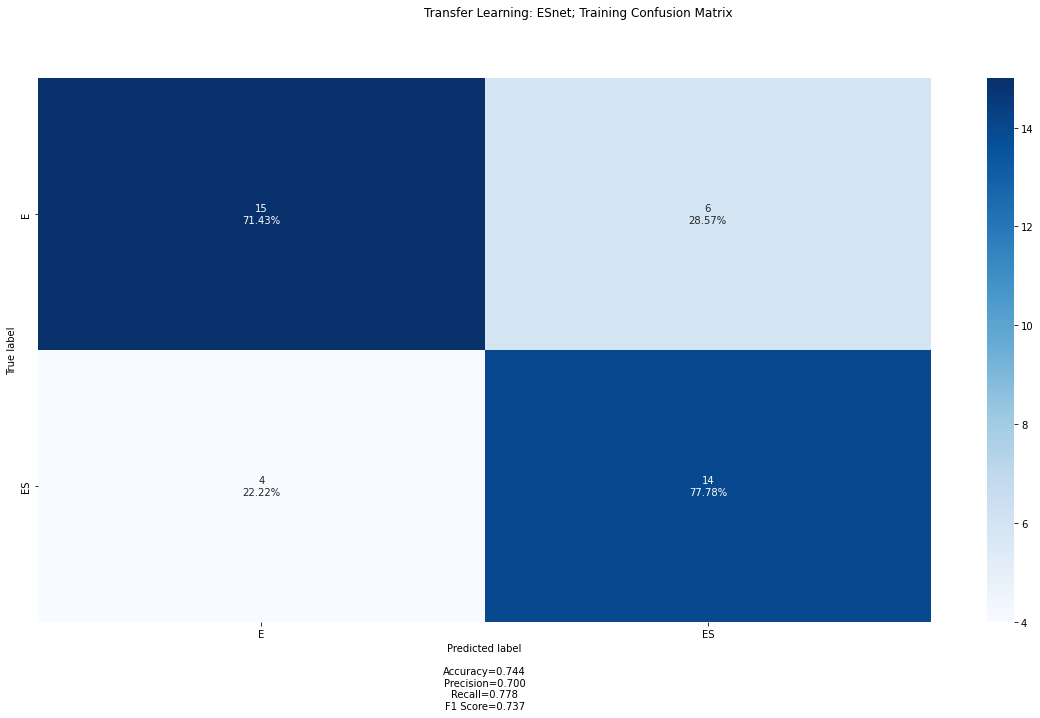

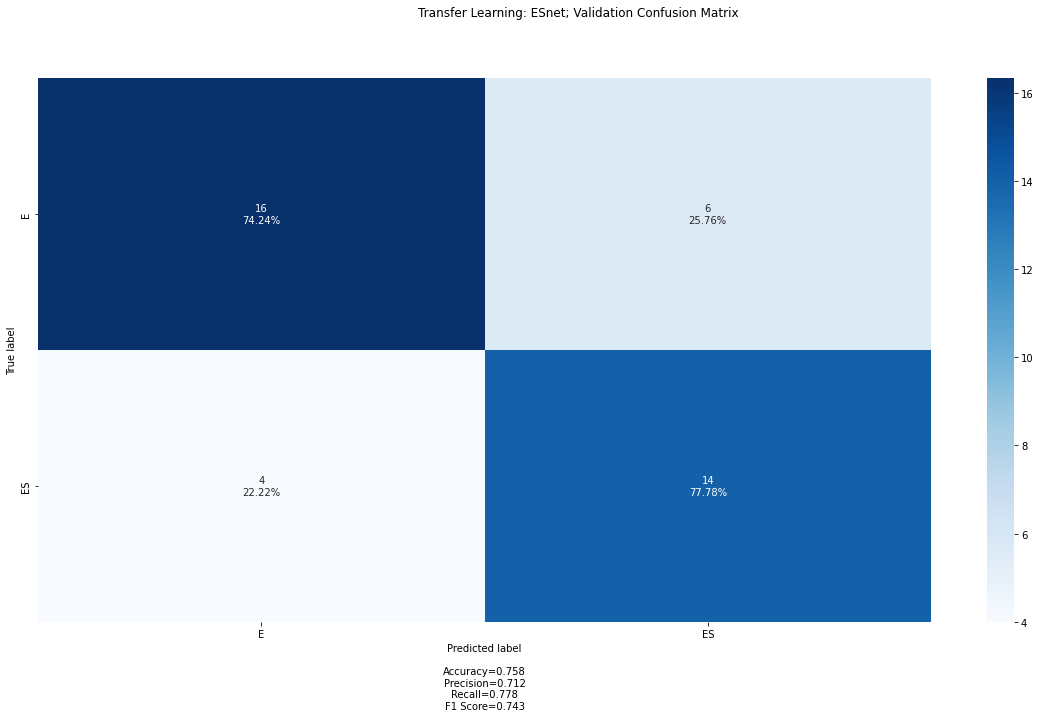

In [12]:
transferred_training_results = []
transferred_validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_cal, y_cal)):
    transferred_model = tf.keras.models.load_model(f"{transfer_model_save_path}_skf={i}")
    #plot_model_results(transferred_model, x_transfer[train_index], y_transfer[train_index], x_transfer[val_index], y_transfer[val_index], x_transfer, y_transfer)
    transferred_training_results.append(get_results(transferred_model, x_cal[train_index], y_cal[train_index]))
    transferred_validation_results.append(get_results(transferred_model, x_cal[val_index], y_cal[val_index]))
plot_results(transferred_training_results, title="Transfer Learning: ESnet; Training Confusion Matrix")
plot_results(transferred_validation_results, title="Transfer Learning: ESnet; Validation Confusion Matrix")


Epoch 1/5000
1/1 [==============================] - 2s 2s/step - loss: 26.5436 - binary_crossentropy: 0.8225 - binary_accuracy: 0.5128 - auc: 0.5437 - val_loss: 8.7425 - val_binary_crossentropy: 0.6892 - val_binary_accuracy: 0.5500 - val_auc: 0.5492
Epoch 2/5000
1/1 [==============================] - 0s 108ms/step - loss: 26.5010 - binary_crossentropy: 0.5949 - binary_accuracy: 0.7179 - auc: 0.7394 - val_loss: 8.7384 - val_binary_crossentropy: 0.6902 - val_binary_accuracy: 0.4750 - val_auc: 0.5366
Epoch 3/5000
1/1 [==============================] - 0s 107ms/step - loss: 26.6296 - binary_crossentropy: 0.8885 - binary_accuracy: 0.5385 - auc: 0.5291 - val_loss: 8.7345 - val_binary_crossentropy: 0.6913 - val_binary_accuracy: 0.5000 - val_auc: 0.5429
Epoch 4/5000
1/1 [==============================] - 0s 101ms/step - loss: 26.2192 - binary_crossentropy: 0.6793 - binary_accuracy: 0.5897 - auc: 0.6627 - val_loss: 8.7304 - val_binary_crossentropy: 0.6922 - val_binary_accuracy: 0.4500 - val_auc

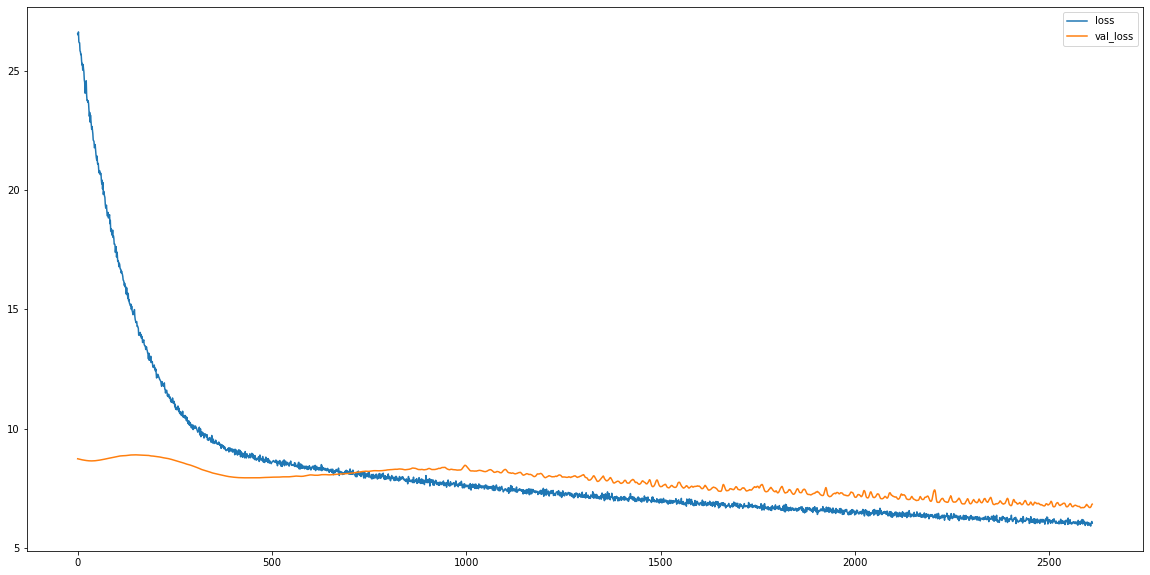

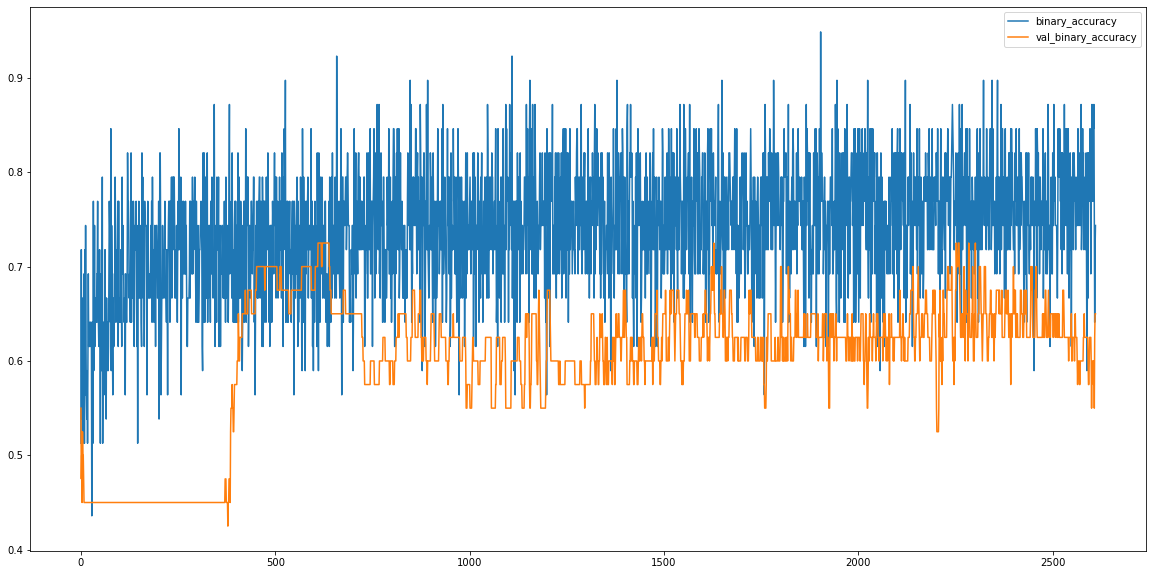

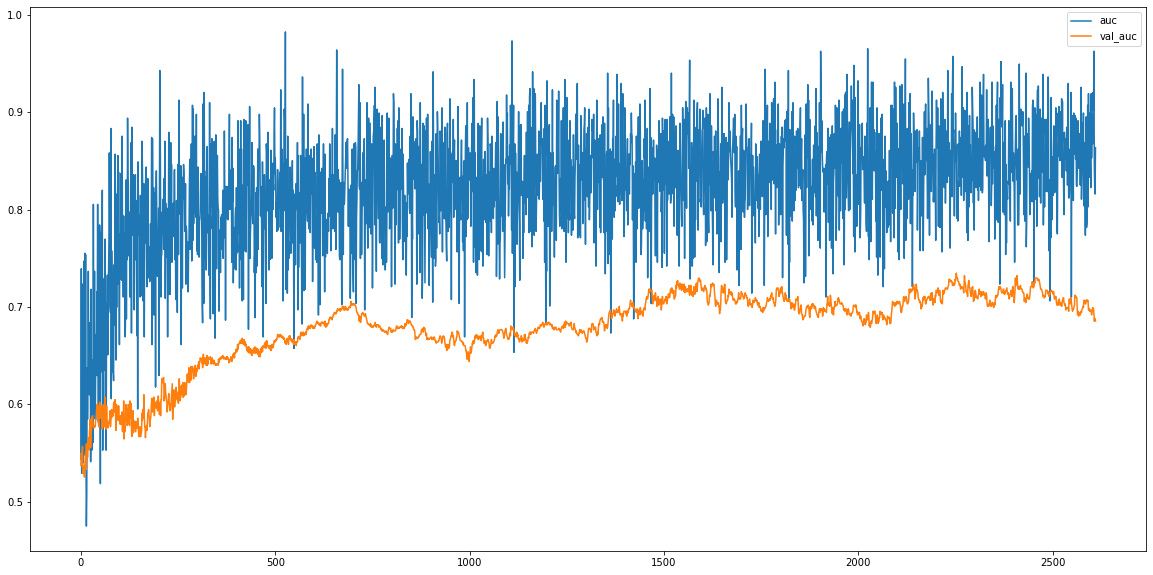

INFO:tensorflow:Assets written to: saved_models\result_models\final\esnet\tuned_skf=0\assets
Epoch 1/5000
1/1 [==============================] - 2s 2s/step - loss: 27.3893 - binary_crossentropy: 1.1404 - binary_accuracy: 0.3846 - auc: 0.4034 - val_loss: 8.7759 - val_binary_crossentropy: 0.7187 - val_binary_accuracy: 0.4500 - val_auc: 0.4646
Epoch 2/5000
1/1 [==============================] - 0s 123ms/step - loss: 27.1651 - binary_crossentropy: 1.3734 - binary_accuracy: 0.3077 - auc: 0.3519 - val_loss: 8.7685 - val_binary_crossentropy: 0.7158 - val_binary_accuracy: 0.4500 - val_auc: 0.4091
Epoch 3/5000
1/1 [==============================] - 0s 113ms/step - loss: 26.4677 - binary_crossentropy: 1.0289 - binary_accuracy: 0.4872 - auc: 0.4339 - val_loss: 8.7615 - val_binary_crossentropy: 0.7131 - val_binary_accuracy: 0.4500 - val_auc: 0.3952
Epoch 4/5000
1/1 [==============================] - 0s 120ms/step - loss: 26.8832 - binary_crossentropy: 0.9541 - binary_accuracy: 0.4615 - auc: 0.4511

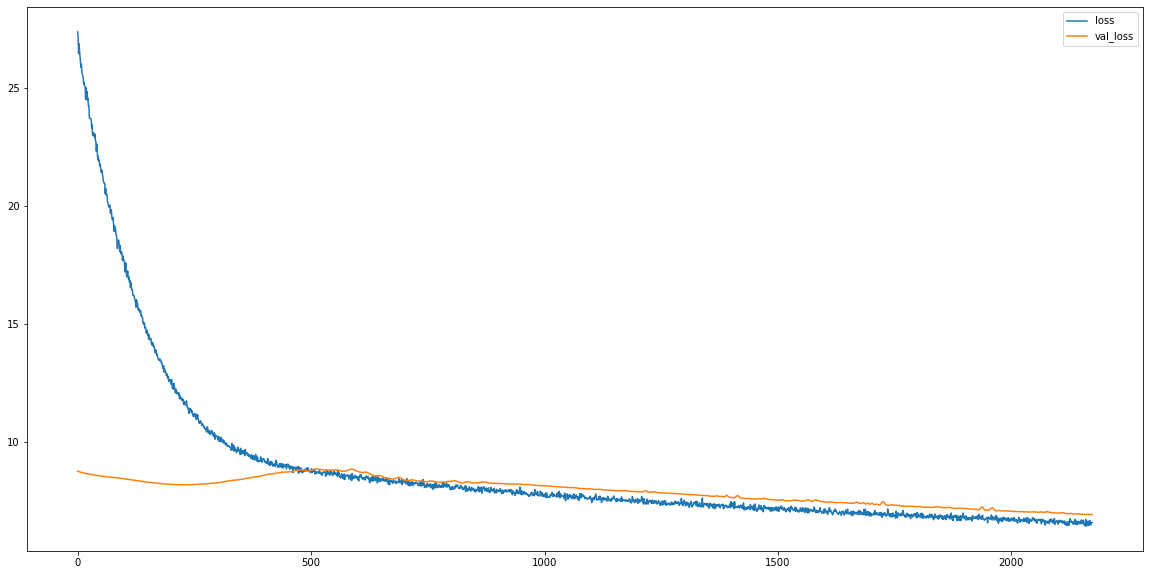

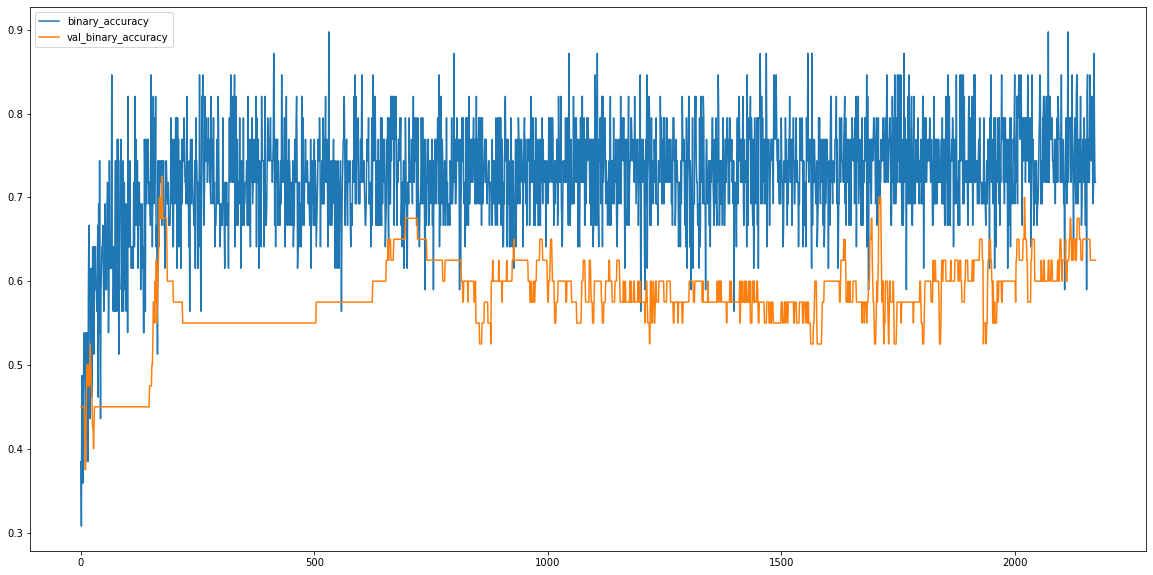

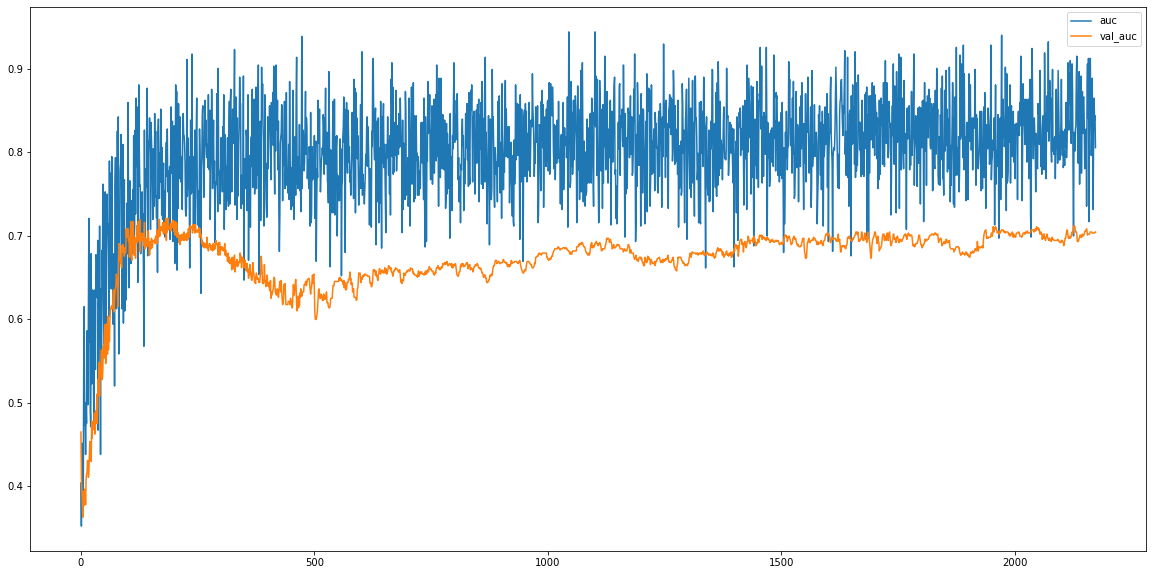

INFO:tensorflow:Assets written to: saved_models\result_models\final\esnet\tuned_skf=1\assets
Epoch 1/5000
1/1 [==============================] - 3s 3s/step - loss: 25.7917 - binary_crossentropy: 0.8355 - binary_accuracy: 0.4615 - auc: 0.5357 - val_loss: 8.8944 - val_binary_crossentropy: 0.6956 - val_binary_accuracy: 0.4000 - val_auc: 0.5013
Epoch 2/5000
1/1 [==============================] - 0s 107ms/step - loss: 25.6347 - binary_crossentropy: 0.9936 - binary_accuracy: 0.5385 - auc: 0.5013 - val_loss: 8.8881 - val_binary_crossentropy: 0.6941 - val_binary_accuracy: 0.4000 - val_auc: 0.5038
Epoch 3/5000
1/1 [==============================] - 0s 103ms/step - loss: 25.3826 - binary_crossentropy: 0.7197 - binary_accuracy: 0.5385 - auc: 0.6032 - val_loss: 8.8820 - val_binary_crossentropy: 0.6930 - val_binary_accuracy: 0.5750 - val_auc: 0.4975
Epoch 4/5000
1/1 [==============================] - 0s 102ms/step - loss: 25.4586 - binary_crossentropy: 0.9339 - binary_accuracy: 0.4872 - auc: 0.4246

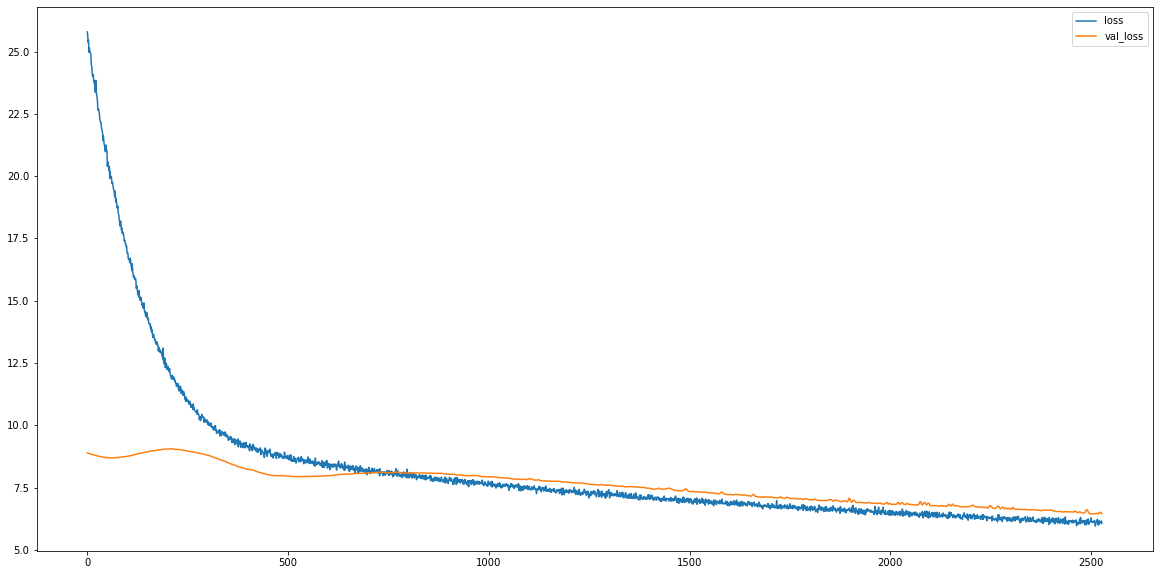

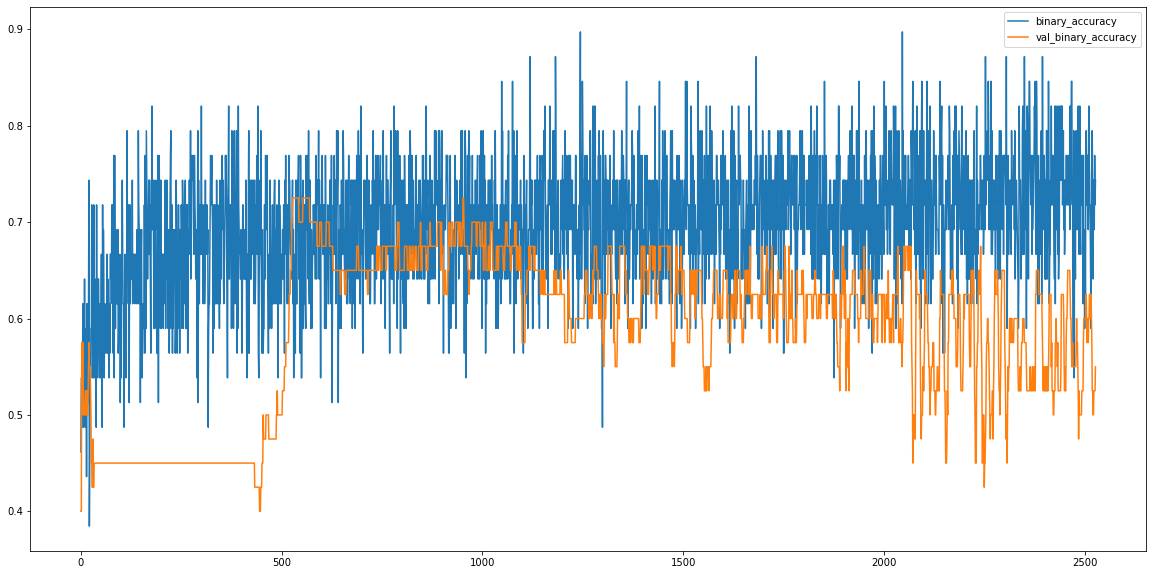

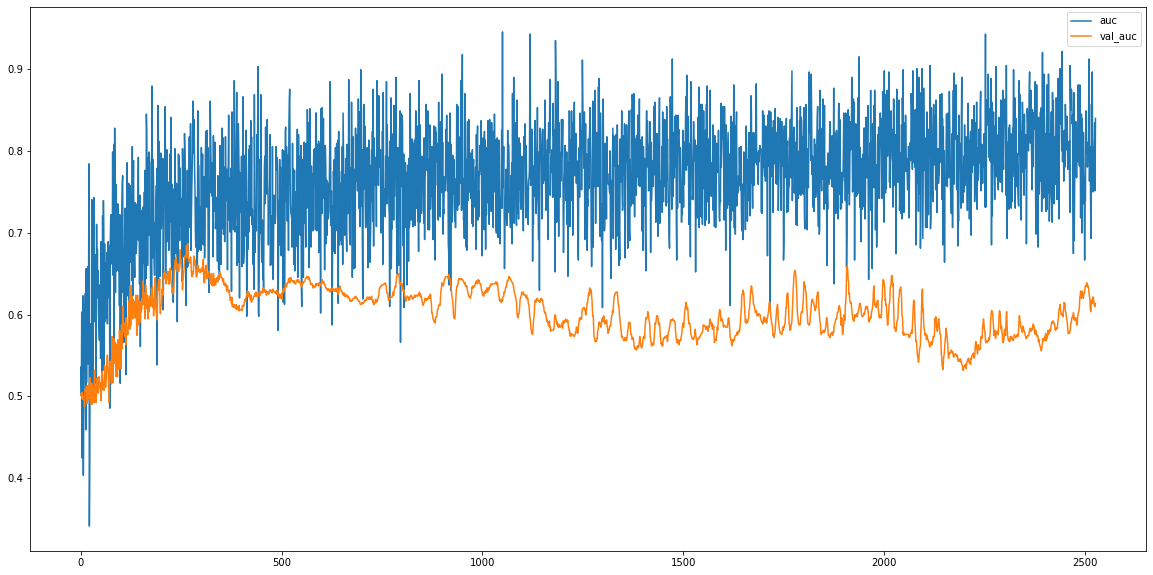

INFO:tensorflow:Assets written to: saved_models\result_models\final\esnet\tuned_skf=2\assets


In [13]:
#model_save_path = f'saved_models\\result_models\\final\\esnet\\sim_with_moffat_noise'
#model = tf.keras.models.load_model(f".\\esnet\\esnet_model_at_24.hdf5")
early_stopping_callback = ReturnBestEarlyStopping(monitor='val_binary_accuracy', patience=2000, restore_best_weights=True, verbose=1)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', patience=3000, cooldown=10)
for i, (train_index, val_index) in enumerate(sss.split(x_cal, y_cal)):
    train_datagen = create_datagen(x_cal[train_index])
    val_datagen = create_datagen(x_cal[val_index])
    transferred_model = tf.keras.models.load_model(f"{transfer_model_save_path}_skf={i}")
    tuned_model, tune_history = esnet.transfer_model(transferred_model, x_cal[train_index], y_cal[train_index], x_cal[val_index], y_cal[val_index],
        datagen = train_datagen, callbacks = [early_stopping_callback], metrics=['binary_accuracy', 'AUC'], epochs = 5000, tuning = True)
    plot_learning_curves(tune_history)
    tuned_model.save(f"{tuned_model_save_path}_skf={i}", overwrite=True)

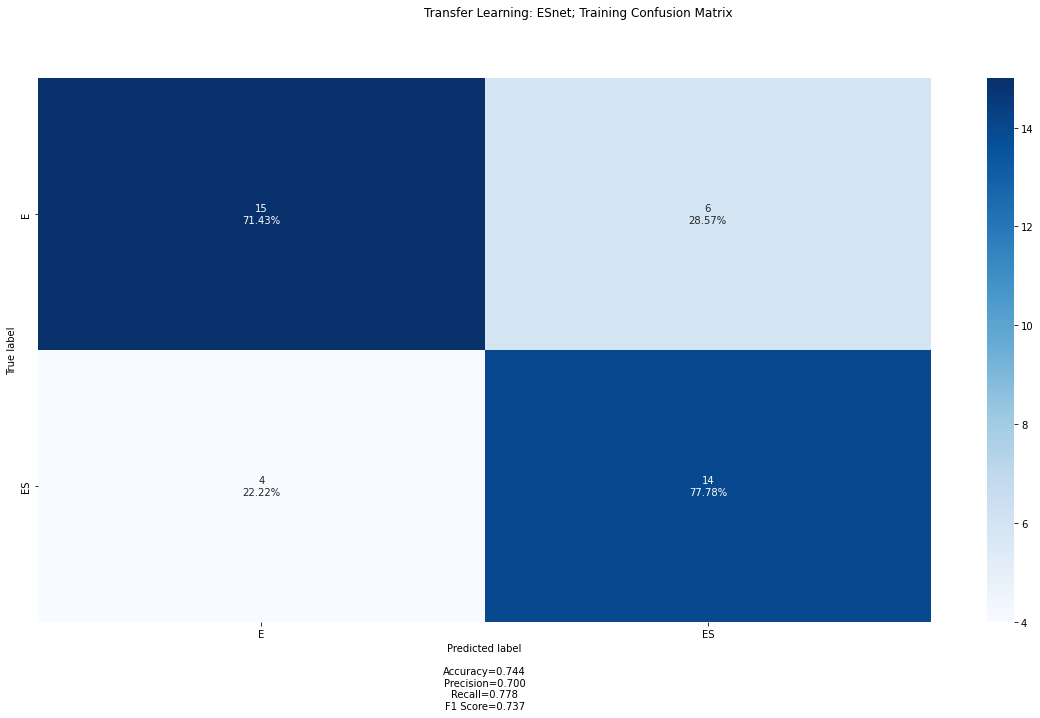

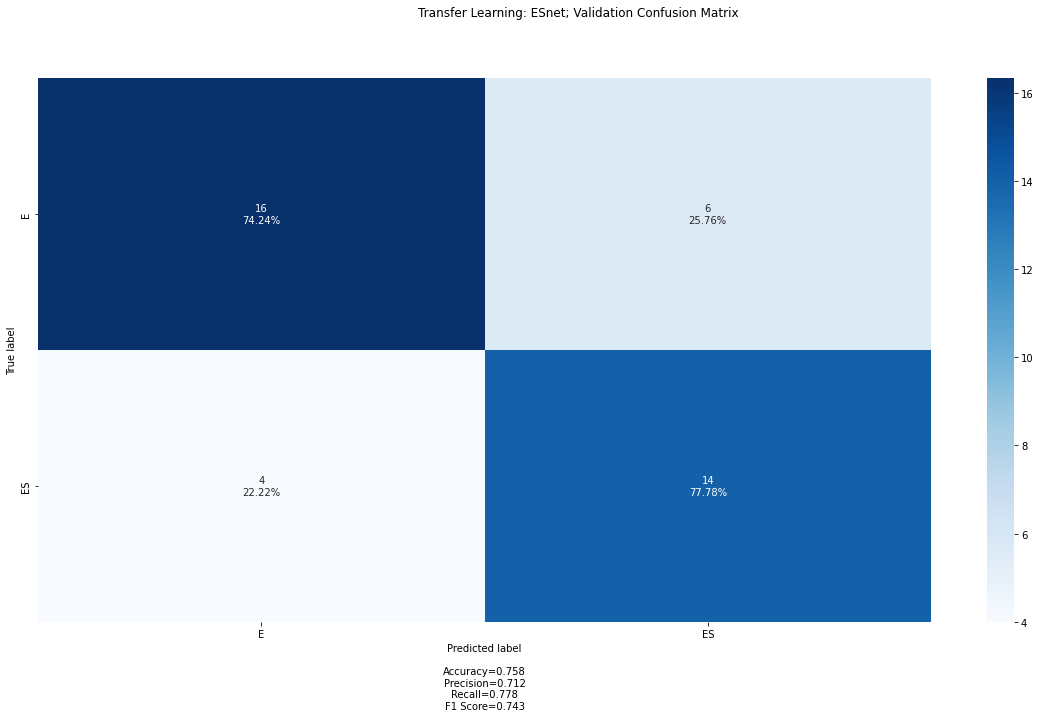

In [14]:
tuned_training_results = []
tuned_validation_results = []
#tuned_model_save_path = f'saved_models\\result_models\\final\\esnet\\tuned_from_sim_with_moffat_noise'

for i, (train_index, val_index) in enumerate(sss.split(x_cal, y_cal)):
    tuned_model = tf.keras.models.load_model(f"{tuned_model_save_path}_skf={i}")
    #plot_model_results(transferred_model, x_transfer[train_index], y_transfer[train_index], x_transfer[val_index], y_transfer[val_index], x_transfer, y_transfer)
    tuned_training_results.append(get_results(tuned_model, x_cal[train_index], y_cal[train_index]))
    tuned_validation_results.append(get_results(tuned_model, x_cal[val_index], y_cal[val_index]))
plot_results(transferred_training_results, title="Transfer Learning: ESnet; Training Confusion Matrix")
plot_results(transferred_validation_results, title="Transfer Learning: ESnet; Validation Confusion Matrix")
